Columns in *.csv file                   Format
----------------------------------------------------------------------------------------------------------------------------------------------------
1.    Timestamp                         Timestamp from the AIS basestation, format: 31/12/2015 23:59:59 

2.    Type of mobile                    Describes what type of target this message is received from (class A AIS Vessel, Class B AIS vessel, etc)

3.    MMSI                              MMSI number of vessel

4.    Latitude                          Latitude of message report (e.g. 57,8794)

5.    Longitude                         Longitude of message report (e.g. 17,9125)

6.    Navigational status               Navigational status from AIS message if available, e.g.: 'Engaged in fishing', 'Under way using engine', mv.

7.    ROT                               Rot of turn from AIS message if available

8.    SOG                               Speed over ground from AIS message if available

9.    COG                               Course over ground from AIS message if available

10.   Heading                           Heading from AIS message if available

11.   IMO                               IMO number of the vessel

12.   Callsign                          Callsign of the vessel 

13.   Name                              Name of the vessel

14.   Ship type                         Describes the AIS ship type of this vessel 

15.   Cargo type                        Type of cargo from the AIS message 

16.   Width                             Width of the vessel

17.   Length                            Lenght of the vessel 

18.   Type of position fixing device    Type of positional fixing device from the AIS message 

19.   Draught                           Draugth field from AIS message

20.   Destination                       Destination from AIS message

21.   ETA                               Estimated Time of Arrival, if available  

22.   Data source type                  Data source type, e.g. AIS

23.   Size A                            Length from GPS to the bow

24.   Size B                            Length from GPS to the stern

25.   Size C                            Length from GPS to starboard side

26.   Size D                            Length from GPS to port side





In [1]:
import pandas as pd
import pyarrow
import pyarrow.parquet
from Dataloader import *
import matplotlib.pyplot as plt
import folium
import os


In [2]:
path = "../aisdk-2025-02-28.zip"
out_path = "../aisdk-2025-02-28.parquet"


In [3]:
if "../aisdk-2025-02-28.parquet" not in os.listdir("../"):
    data = Dataloader(path, out_path)
    data.clean_data()


c:\Users\canic\OneDrive\DTU\Deep_learning\Exercises\project\Increasing-Maritime-Domain-Awareness-using-spatio-temporal-sequential-data\Dataloader.py:171: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['distance_km'] = df.groupby(['MMSI', 'Segment']).apply(


Loading land polygons from cartopy...
Checking for land positions...
Found 7622 speed anomalies (>50 knots)
Found 95563 land positions
Total anomalies: 102949


c:\Users\canic\OneDrive\DTU\Deep_learning\Exercises\project\Increasing-Maritime-Domain-Awareness-using-spatio-temporal-sequential-data\Dataloader.py:228: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["MMSI", "Segment"], group_keys=False).apply(downsample_group).reset_index(drop=True)


In [4]:
df = pd.read_parquet(out_path)
df

,Timestamp,Latitude,Longitude,SOG,COG,Ship type,Width,Length,Destination,distance_km,time_diff_hours,implied_speed_knots,anomaly,MMSI,Segment
0,2025-02-28 21:33:29,54.169252,14.591962,5.504551,45.7,Cargo,15.0,120.0,FIPRS,0.000000,NaN,NaN,False,209314000,0
1,2025-02-28 21:34:08,54.174753,14.601583,5.453106,45.1,Cargo,15.0,120.0,FIPRS,0.877315,0.010833,43.727267,False,209314000,0
2,2025-02-28 21:34:17,54.175098,14.602188,5.453106,44.8,Cargo,15.0,120.0,FIPRS,0.055095,0.002500,11.899557,False,209314000,0
3,2025-02-28 21:34:28,54.175478,14.602850,5.504551,45.1,Cargo,15.0,120.0,FIPRS,0.060479,0.003056,10.687506,False,209314000,0
4,2025-02-28 21:34:39,54.175857,14.603508,5.504551,45.5,Cargo,15.0,120.0,FIPRS,0.060215,0.003056,10.640724,False,209314000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75132,2025-02-28 06:45:25,57.584322,11.668785,0.257222,160.5,Cargo,32.0,199.0,SEGOT,0.000000,0.013333,0.000000,False,636022830,0
75133,2025-02-28 06:50:37,57.583603,11.669067,0.205778,176.0,Cargo,32.0,199.0,SEGOT,0.081833,0.086667,0.509840,False,636022830,0
75134,2025-02-28 06:53:37,57.583342,11.669270,0.154333,114.1,Cargo,32.0,199.0,SEGOT,0.031502,0.050000,0.340195,False,636022830,0
75135,2025-02-28 06:56:37,57.583357,11.669732,0.102889,52.9,Cargo,32.0,199.0,SEGOT,0.027686,0.050000,0.298989,False,636022830,0


In [5]:
# Visualize every vessel's trajectory on a map - RESPECTING SEGMENTS
m = folium.Map(location=[55.6761, 12.5683], zoom_start=6)

# Plot each vessel's trajectory, with separate polylines for each segment
for vessel_id in df["MMSI"].unique():
    vessel_data = df[df["MMSI"] == vessel_id]
    
    # Group by segment and plot each segment separately
    for segment_id, segment in vessel_data.groupby('Segment'):
        # Sort by timestamp within the segment
        segment = segment.sort_values('Timestamp')
        
        # Extract coordinates
        points = list(zip(segment['Latitude'], segment['Longitude']))
        
        # Only plot if we have at least 2 points to make a line
        if len(points) >= 2:
            folium.PolyLine(
                locations=points,
                color="blue",
                weight=2,
                opacity=0.6,
                popup=f"Vessel {vessel_id}<br>Segment {segment_id}<br>{len(points)} points"
            ).add_to(m)

m

C:\Users\canic\AppData\Local\Temp\ipykernel_8980\2202372441.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for segment_id, segment in vessel_data.groupby('Segment'):


---

In [5]:
from geopy.distance import geodesic
import cartopy.feature as cfeature
from shapely.geometry import Point
from shapely.ops import unary_union
from shapely.prepared import prep

def detect_anomalies(df, max_speed_knots=50):
    """Flag physically impossible movements and land positions"""
    df = df.sort_values(['MMSI', 'Segment', 'Timestamp'])
    
    # Calculate distance between consecutive points
    def calc_distance(group):
        coords = list(zip(group['Latitude'], group['Longitude']))
        distances = [geodesic(coords[i], coords[i+1]).km 
                    for i in range(len(coords)-1)]
        return [0] + distances  # First point has no previous point
    
    df['distance_km'] = df.groupby(['MMSI', 'Segment']).apply(
        lambda g: calc_distance(g)
    ).explode().values
    
    # Calculate time difference
    df['time_diff_hours'] = df.groupby(['MMSI', 'Segment'])['Timestamp'].diff().dt.total_seconds() / 3600
    
    # Calculate implied speed
    df['implied_speed_knots'] = (df['distance_km'] / df['time_diff_hours']) / 1.852
    
    # Flag speed anomalies
    speed_anomaly = df['implied_speed_knots'] > max_speed_knots
    
    # === ADD: Check if positions are on land using cartopy ===
    print("Loading land polygons from cartopy...")
    land_geom = list(cfeature.LAND.geometries())
    land = prep(unary_union(land_geom))
    
    print("Checking for land positions...")
    def is_on_land(lat, lon):
        point = Point(lon, lat)  # Shapely uses (lon, lat) order
        return land.contains(point)
    
    # Apply to all rows
    is_land = df.apply(lambda row: is_on_land(row['Latitude'], row['Longitude']), axis=1)
    
    # Combine both anomaly types
    df['anomaly'] = speed_anomaly | is_land
    
    # Print statistics
    print(f"Found {speed_anomaly.sum()} speed anomalies (>{max_speed_knots} knots)")
    print(f"Found {is_land.sum()} land positions")
    print(f"Total anomalies: {df['anomaly'].sum()}")
    
    return df

df = detect_anomalies(df)

C:\Users\canic\AppData\Local\Temp\ipykernel_26920\1021602943.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['distance_km'] = df.groupby(['MMSI', 'Segment']).apply(
C:\Users\canic\AppData\Local\Temp\ipykernel_26920\1021602943.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['distance_km'] = df.groupby(['MMSI', 'Segment']).apply(
C:\Users\canic\AppData\Local\Temp\ipykernel_26920\1021602943.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future versi

Loading land polygons from cartopy...
Checking for land positions...
Found 7622 speed anomalies (>50 knots)
Found 95563 land positions
Total anomalies: 102949


In [6]:
anomalies = df[df["anomaly"] == True]
anomalies[["MMSI", "Segment"]]
# Now we delete every row in the dataframe with these MMSI and Segment combinations
# and keep only the segments without anomalies
df = df[~df.set_index(['MMSI', 'Segment']).index.isin(anomalies.set_index(['MMSI', 'Segment']).index)]
df

,Timestamp,Latitude,Longitude,SOG,COG,Ship type,Width,Length,Destination,MMSI,Segment,distance_km,time_diff_hours,implied_speed_knots,anomaly
0,2025-02-28 21:33:29,54.169252,14.591962,5.504551,45.7,Cargo,15.0,120.0,FIPRS,209314000,0,0,NaN,NaN,False
1,2025-02-28 21:34:08,54.174753,14.601583,5.453106,45.1,Cargo,15.0,120.0,FIPRS,209314000,0,0.877315,0.010833,43.727267,False
2,2025-02-28 21:34:17,54.175098,14.602188,5.453106,44.8,Cargo,15.0,120.0,FIPRS,209314000,0,0.055095,0.002500,11.899557,False
3,2025-02-28 21:34:28,54.175478,14.602850,5.504551,45.1,Cargo,15.0,120.0,FIPRS,209314000,0,0.060479,0.003056,10.687506,False
4,2025-02-28 21:34:39,54.175857,14.603508,5.504551,45.5,Cargo,15.0,120.0,FIPRS,209314000,0,0.060215,0.003056,10.640724,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178722,2025-02-28 06:45:25,57.584322,11.668785,0.257222,160.5,Cargo,32.0,199.0,SEGOT,636022830,0,0.0,0.013333,0.0,False
1178723,2025-02-28 06:50:37,57.583603,11.669067,0.205778,176.0,Cargo,32.0,199.0,SEGOT,636022830,0,0.081833,0.086667,0.50984,False
1178724,2025-02-28 06:53:37,57.583342,11.669270,0.154333,114.1,Cargo,32.0,199.0,SEGOT,636022830,0,0.031502,0.050000,0.340195,False
1178725,2025-02-28 06:56:37,57.583357,11.669732,0.102889,52.9,Cargo,32.0,199.0,SEGOT,636022830,0,0.027686,0.050000,0.298989,False


---

In [ ]:
from geopy.distance import geodesic

def detect_speed_anomalies(df, max_speed_knots=50):
    """Flag physically impossible movements"""
    df = df.sort_values(['MMSI', 'Segment', 'Timestamp'])
    
    # Calculate distance between consecutive points
    def calc_distance(group):
        coords = list(zip(group['Latitude'], group['Longitude']))
        distances = [geodesic(coords[i], coords[i+1]).km 
                    for i in range(len(coords)-1)]
        return [0] + distances  # First point has no previous point
    
    df['distance_km'] = df.groupby(['MMSI', 'Segment']).apply(
        lambda g: calc_distance(g)
    ).explode().values
    
    # Calculate time difference
    df['time_diff_hours'] = df.groupby(['MMSI', 'Segment'])['Timestamp'].diff().dt.total_seconds() / 3600
    
    # Calculate implied speed
    df['implied_speed_knots'] = (df['distance_km'] / df['time_diff_hours']) / 1.852
    
    # Flag anomalies
    df['anomaly'] = df['implied_speed_knots'] > max_speed_knots
    
    print(f"Found {df['anomaly'].sum()} speed anomalies (>{max_speed_knots} knots)")
    return df

df = detect_speed_anomalies(df)

C:\Users\canic\AppData\Local\Temp\ipykernel_34336\1534403944.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['distance_km'] = df.groupby(['MMSI', 'Segment']).apply(


Found 18 speed anomalies (>50 knots)


C:\Users\canic\AppData\Local\Temp\ipykernel_34336\1534403944.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['distance_km'] = df.groupby(['MMSI', 'Segment']).apply(
C:\Users\canic\AppData\Local\Temp\ipykernel_34336\1534403944.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['time_diff_hours'] = df.groupby(['MMSI', 'Segment'])['Timestamp'].diff().dt.total_seconds() / 3600


In [38]:
anomalies = df[df["speed_anomaly"] == True]
anomalies[["MMSI", "Segment"]]
# Now we delete every row in the dataframe with these MMSI and Segment combinations
# and keep only the segments without anomalies
df = df[~df.set_index(['MMSI', 'Segment']).index.isin(anomalies.set_index(['MMSI', 'Segment']).index)]

In [12]:
# Verify downsampling worked correctly
print("Downsampling verification:")
sample_vessel = df.groupby(['MMSI', 'Segment']).size().reset_index(name='count')
print(f"Segments after downsampling:\n{sample_vessel.head(10)}")

# Check time gaps within segments
for (mmsi, seg), group in df.groupby(['MMSI', 'Segment']):
    time_diffs = group.sort_values('Timestamp')['Timestamp'].diff().dt.total_seconds() / 60
    min_gap = time_diffs.min()
    if min_gap < 10 and pd.notna(min_gap):
        print(f"⚠️  MMSI {mmsi}, Segment {seg}: Min gap = {min_gap:.1f} min (should be ≥1)")
        break
else:
    print("✅ All segments have ≥x min gaps between points")

Downsampling verification:
Segments after downsampling:
        MMSI Segment  count
0  209314000       0     33
1  209314000       1      0
2  209314000       4      0
3  209314000       3      0
4  209314000       6      0
5  209314000       5      0
6  209314000       2      0
7  209314000      10      0
8  209314000      20      0
9  209314000       8      0
⚠️  MMSI 209314000, Segment 0: Min gap = 0.7 min (should be ≥1)


C:\Users\canic\AppData\Local\Temp\ipykernel_25740\724830657.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_vessel = df.groupby(['MMSI', 'Segment']).size().reset_index(name='count')
C:\Users\canic\AppData\Local\Temp\ipykernel_25740\724830657.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (mmsi, seg), group in df.groupby(['MMSI', 'Segment']):


In [13]:
# Redefine vessel_id in this cell
vessel_id = df['MMSI'].unique()[3]  # Or use a specific MMSI: "209530000"
print(f"Selected vessel: {vessel_id}")

# Now filter
vessel_data = df[df["MMSI"] == vessel_id]
print(f"Found {len(vessel_data)} rows for this vessel")
print(f"Segments: {vessel_data['Segment'].unique()}")

# Display
vessel_data

Selected vessel: 209530000
Found 18 rows for this vessel
Segments: [0]
Categories (9, int32): [0, 1, 5, 3, ..., 4, 7, 6, 8]


,Timestamp,Latitude,Longitude,SOG,COG,Ship type,Width,Length,Destination,MMSI,Segment
315,2025-02-28 14:28:04,55.600842,12.483528,0.0,2.0,Cargo,14.0,111.0,FIKTK,209530000,0
316,2025-02-28 14:31:24,55.600838,12.483525,0.0,12.1,Cargo,14.0,111.0,FIKTK,209530000,0
317,2025-02-28 14:34:04,55.600838,12.483525,0.0,12.1,Cargo,14.0,111.0,FIKTK,209530000,0
318,2025-02-28 14:37:25,55.600825,12.483530,0.0,51.7,Cargo,14.0,111.0,FIKTK,209530000,0
319,2025-02-28 14:40:05,55.600825,12.483530,0.0,51.7,Cargo,14.0,111.0,FIKTK,209530000,0
320,2025-02-28 14:43:25,55.600828,12.483525,0.0,41.6,Cargo,14.0,111.0,FIKTK,209530000,0
321,2025-02-28 14:46:05,55.600828,12.483525,0.0,41.6,Cargo,14.0,111.0,FIKTK,209530000,0
322,2025-02-28 14:52:05,55.600858,12.483548,0.0,5.6,Cargo,14.0,111.0,FIKTK,209530000,0
323,2025-02-28 14:55:25,55.600840,12.483545,0.0,357.5,Cargo,14.0,111.0,FIKTK,209530000,0
324,2025-02-28 14:58:06,55.600840,12.483545,0.0,357.5,Cargo,14.0,111.0,FIKTK,209530000,0


In [6]:
# plot the first 5 segments of a vessel making sure the end and start points are clearly visible and not connected. It should be done in folium
vessel_id = df['MMSI'].unique()[3] # Example vessel MMSI
vessel_data = df[df['MMSI'] == vessel_id]
vessel_data = vessel_data.sort_values(['Segment', 'Timestamp'])
m = folium.Map(location=[vessel_data['Latitude'].mean(), vessel_data['Longitude'].mean()], zoom_start=6)
segments = vessel_data['Segment'].unique()[:5]
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i, seg in enumerate(segments):
    seg_data = vessel_data[vessel_data['Segment'] == seg]
    points = list(zip(seg_data['Latitude'], seg_data['Longitude']))
    folium.PolyLine(points, color=colors[i], weight=5, opacity=0.8).add_to(m)
    folium.Marker(points[0], icon=folium.Icon(color='black', icon='play')).add_to(m)
    folium.Marker(points[-1], icon=folium.Icon(color='black', icon='stop')).add_to(m)
m


---

In [12]:
df[df["MMSI"] == vessel_id]

,Timestamp,Latitude,Longitude,SOG,COG,Ship type,Width,Length,Destination,MMSI,Segment
315,2025-02-28 14:28:04,55.600842,12.483528,0.0,2.0,Cargo,14.0,111.0,FIKTK,209530000,0
316,2025-02-28 14:31:24,55.600838,12.483525,0.0,12.1,Cargo,14.0,111.0,FIKTK,209530000,0
317,2025-02-28 14:34:04,55.600838,12.483525,0.0,12.1,Cargo,14.0,111.0,FIKTK,209530000,0
318,2025-02-28 14:37:25,55.600825,12.483530,0.0,51.7,Cargo,14.0,111.0,FIKTK,209530000,0
319,2025-02-28 14:40:05,55.600825,12.483530,0.0,51.7,Cargo,14.0,111.0,FIKTK,209530000,0
320,2025-02-28 14:43:25,55.600828,12.483525,0.0,41.6,Cargo,14.0,111.0,FIKTK,209530000,0
321,2025-02-28 14:46:05,55.600828,12.483525,0.0,41.6,Cargo,14.0,111.0,FIKTK,209530000,0
322,2025-02-28 14:52:05,55.600858,12.483548,0.0,5.6,Cargo,14.0,111.0,FIKTK,209530000,0
323,2025-02-28 14:55:25,55.600840,12.483545,0.0,357.5,Cargo,14.0,111.0,FIKTK,209530000,0
324,2025-02-28 14:58:06,55.600840,12.483545,0.0,357.5,Cargo,14.0,111.0,FIKTK,209530000,0


Text(0, 0.5, 'Speed (m/s)')

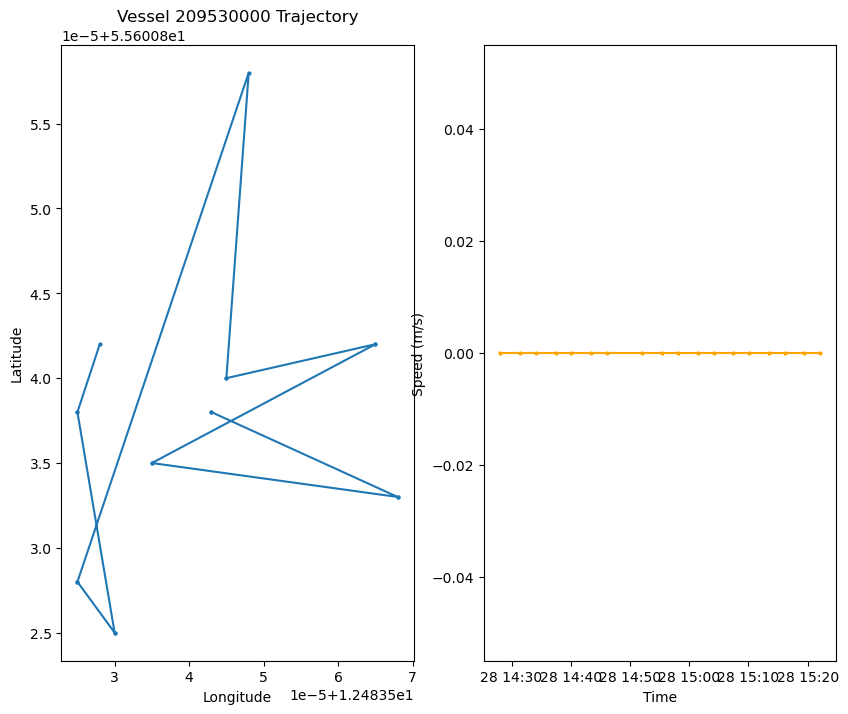

In [6]:
# plot a single vessel's trajectory
vessel_id = df['MMSI'].unique()[3]
vessel_data = df[df['MMSI'] == vessel_id].sort_values(by='Timestamp')
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
axes[0].plot(vessel_data['Longitude'], vessel_data['Latitude'], marker='o', markersize=2)
axes[0].set_title(f'Vessel {vessel_id} Trajectory')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[1].plot(vessel_data['Timestamp'], vessel_data['SOG'], marker='o', markersize=2, color='orange')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Speed (m/s)')

In [26]:
# Enhanced version with segment markers
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)

colors = ['blue', 'red', 'green', 'purple', 'orange']

for i, vessel_id in enumerate(df['MMSI'].unique()[:3]):
    vessel_data = df[df['MMSI'] == vessel_id]
    color = colors[i % len(colors)]
    
    # Plot each segment separately
    for segment_id, segment in vessel_data.groupby('Segment'):
        segment = segment.sort_values(by='Timestamp')
        points = list(zip(segment['Latitude'], segment['Longitude']))
        
        if len(points) >= 2:
            # Draw the trajectory
            folium.PolyLine(
                points, 
                color=color, 
                weight=2.5, 
                opacity=0.7,
                popup=f'MMSI: {vessel_id}<br>Segment: {segment_id}<br>Points: {len(points)}'
            ).add_to(m)
            
            # Add start marker (green circle)
            folium.CircleMarker(
                location=points[0],
                radius=5,
                color='green',
                fill=True,
                popup=f'Start: Seg {segment_id}'
            ).add_to(m)
            
            # Add end marker (red circle)
            folium.CircleMarker(
                location=points[-1],
                radius=5,
                color='red',
                fill=True,
                popup=f'End: Seg {segment_id}'
            ).add_to(m)

m

C:\Users\canic\AppData\Local\Temp\ipykernel_29020\1802231000.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for segment_id, segment in vessel_data.groupby('Segment'):


In [27]:
# Check how many segments each vessel has
segments_per_vessel = df.groupby('MMSI')['Segment'].nunique()
print(f"Vessels with 1 segment: {(segments_per_vessel == 1).sum()}")
print(f"Vessels with 2+ segments: {(segments_per_vessel > 1).sum()}")

# Show vessels with multiple segments
multi_seg = segments_per_vessel[segments_per_vessel > 1]
print(f"\nExample multi-segment vessels:")
print(multi_seg.head())

Vessels with 1 segment: 259
Vessels with 2+ segments: 28

Example multi-segment vessels:
MMSI
209664000    2
209974000    2
211815120    2
212797000    2
218005000    2
Name: Segment, dtype: int64


C:\Users\canic\AppData\Local\Temp\ipykernel_29020\2174808394.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segments_per_vessel = df.groupby('MMSI')['Segment'].nunique()


Issue with segment data if the sailing continues after midnight and into the next day...

Time stamp: date and time

Latitude: breddegrad

Longitude: længdegrad

SOG: Speed Over Ground

COG: Course Over Ground

MMSI: Maritime Mobile Service Identity (ID pretty much)

Segment: ???

In [16]:
# Basic stats
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22442 entries, 0 to 22441
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Timestamp    22442 non-null  datetime64[ns]
 1   Latitude     22442 non-null  float64       
 2   Longitude    22442 non-null  float64       
 3   SOG          22442 non-null  float64       
 4   COG          21835 non-null  float64       
 5   Ship type    22442 non-null  category      
 6   Width        22442 non-null  float64       
 7   Length       22442 non-null  float64       
 8   Destination  22442 non-null  category      
 9   MMSI         22442 non-null  category      
 10  Segment      22442 non-null  category      
dtypes: category(4), datetime64[ns](1), float64(6)
memory usage: 1.3 MB
None


In [17]:
print(df.describe())


                           Timestamp      Latitude     Longitude  \
count                          22442  22442.000000  22442.000000   
mean   2025-02-28 11:37:23.077443840     55.954596     10.791332   
min              2025-02-28 00:00:02     53.838353      2.437512   
25%              2025-02-28 05:55:28     55.040565      9.755793   
50%       2025-02-28 11:30:15.500000     55.855883     10.343860   
75%              2025-02-28 17:15:21     57.048880     12.013731   
max              2025-02-28 23:59:55     59.377233     17.242517   
std                              NaN      1.090077      1.817619   

                SOG           COG         Width        Length  
count  22442.000000  21835.000000  22442.000000  22442.000000  
mean       0.757098    188.147300     18.035202    111.172445  
min        0.000000      0.000000      4.000000     10.000000  
25%        0.000000     84.200000     12.000000     85.000000  
50%        0.000000    195.600000     15.000000     90.000000  
75%

In [18]:
print(f"Total records: {len(df)}")
print(f"Unique vessels: {df['MMSI'].nunique()}")
print(f"Date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}") # for the entire day
print(f"Unique segments: {df.groupby(['MMSI', 'Segment']).ngroups}")

Total records: 22442
Unique vessels: 287
Date range: 2025-02-28 00:00:02 to 2025-02-28 23:59:55
Unique segments: 315


C:\Users\canic\AppData\Local\Temp\ipykernel_19928\2704259542.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f"Unique segments: {df.groupby(['MMSI', 'Segment']).ngroups}")


In [19]:
print(f"Taking a look at a random vessel's segments: {df['MMSI'].sample().values}")

Taking a look at a random vessel's segments: [210051000]
Categories (287, int32): [209314000, 209336000, 209415000, 209530000, ..., 636092297, 636092750, 636093199, 636093238]


C:\Users\canic\AppData\Local\Temp\ipykernel_528\1052644578.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for segment_id, segment in vessel_data.groupby('Segment'):
C:\Users\canic\AppData\Local\Temp\ipykernel_528\1052644578.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for segment_id, segment in vessel_data.groupby('Segment'):


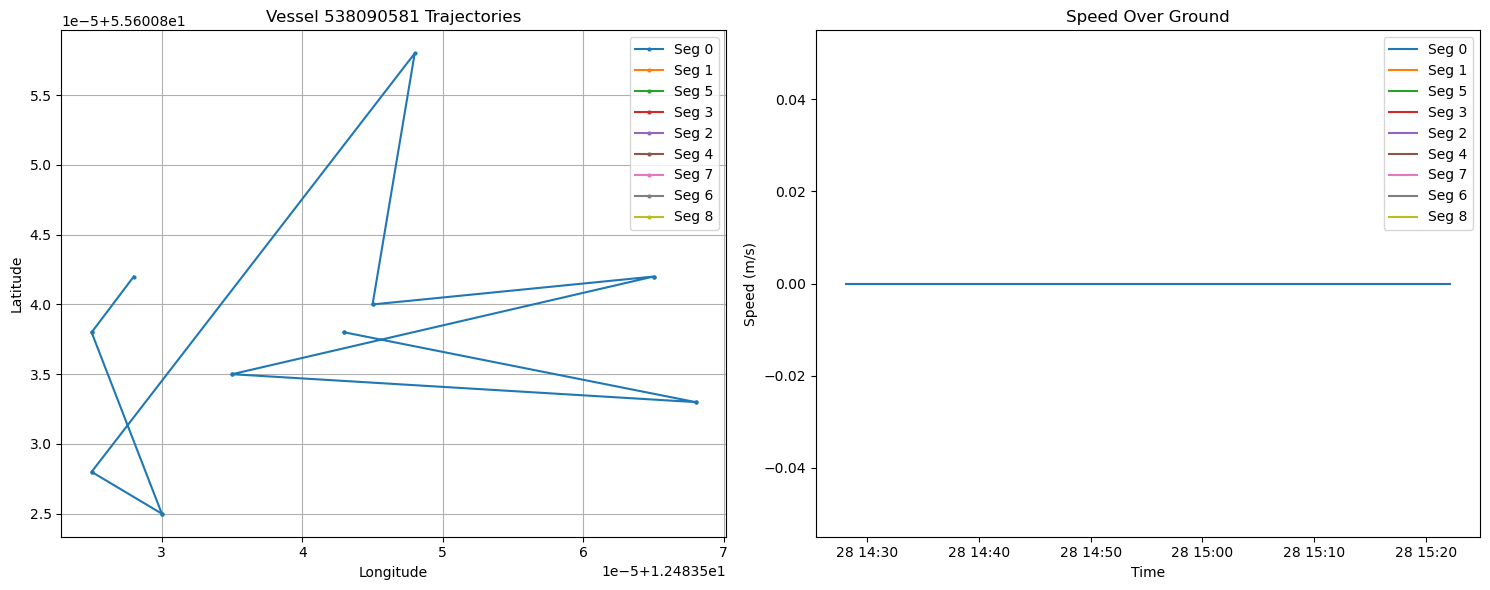

In [9]:
import matplotlib.pyplot as plt

# Pick one vessel with multiple segments
sample_mmsi = df['MMSI'].value_counts().index[0]
vessel_data = df[df['MMSI'] == vessel_id]
# IMPORTANT: Sort by Timestamp to ensure correct order
vessel_data = vessel_data.sort_values(['Segment', 'Timestamp'])

# Plot all segments for this vessel
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Geographic plot
for segment_id, segment in vessel_data.groupby('Segment'):
    # Segment is now guaranteed to be time-ordered
    axes[0].plot(segment['Longitude'], segment['Latitude'], 
                 marker='o', markersize=2, label=f'Seg {segment_id}')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title(f'Vessel {sample_mmsi} Trajectories')
axes[0].legend()
axes[0].grid(True)

# Speed over time
for segment_id, segment in vessel_data.groupby('Segment'):
    axes[1].plot(segment['Timestamp'], segment['SOG'], label=f'Seg {segment_id}')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Speed (m/s)')
axes[1].set_title('Speed Over Ground')
axes[1].legend()
plt.tight_layout()
plt.show()

In [10]:
import folium
import pandas as pd


# First, verify your data exists
print(f"Total rows in vessel_data: {len(vessel_data)}")
print(f"Columns: {vessel_data.columns.tolist()}")
print(f"Lat/Lon sample:\n{vessel_data[['Latitude', 'Longitude']].head()}")

# Check for NaN values that could cause issues
print(f"Missing Latitude values: {vessel_data['Latitude'].isna().sum()}")
print(f"Missing Longitude values: {vessel_data['Longitude'].isna().sum()}")

# Create a map centered around the vessel's average location
# Use dropna() to exclude NaN values from the mean calculation
map_center = [
    vessel_data['Latitude'].dropna().mean(), 
    vessel_data['Longitude'].dropna().mean()
]
m = folium.Map(location=map_center, zoom_start=6)

# Add vessel tracks to the map with validation
for segment_id, segment in vessel_data.groupby('Segment'):
    # Extract coordinates and remove any rows with NaN values
    coords = segment[['Latitude', 'Longitude']].dropna().values
    
    # Only add the polyline if we have at least 2 points (a line needs 2 points)
    if len(coords) >= 2:
        folium.PolyLine(
            locations=coords, 
            color='blue', 
            weight=2, 
            opacity=0.6,
            popup=f'Segment {segment_id}'  # Optional: add segment identifier
        ).add_to(m)
    else:
        print(f"Warning: Segment {segment_id} has insufficient points ({len(coords)}), skipping.")

# Display the map
m

Total rows in vessel_data: 18
Columns: ['Timestamp', 'Latitude', 'Longitude', 'SOG', 'COG', 'Ship type', 'Width', 'Length', 'Destination', 'MMSI', 'Segment']
Lat/Lon sample:
      Latitude  Longitude
315  55.600842  12.483528
316  55.600838  12.483525
317  55.600838  12.483525
318  55.600825  12.483530
319  55.600825  12.483530
Missing Latitude values: 0
Missing Longitude values: 0


C:\Users\canic\AppData\Local\Temp\ipykernel_528\2573906439.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for segment_id, segment in vessel_data.groupby('Segment'):


In [9]:
# Segment statistics
segment_stats = df.groupby(['MMSI', 'Segment']).agg({
    'Timestamp': ['min', 'max', 'count'],
    'Latitude': ['min', 'max'],
    'Longitude': ['min', 'max'],
    'SOG': ['mean', 'max'],
    'COG': 'mean'
}).reset_index()

segment_stats.columns = ['_'.join(col).strip('_') for col in segment_stats.columns]
segment_stats['duration_hours'] = (
    (segment_stats['Timestamp_max'] - segment_stats['Timestamp_min']).dt.total_seconds() / 3600
)

print(segment_stats.head())
print(f"\nAverage segment length: {segment_stats['Timestamp_count'].mean():.0f} points")
print(f"Average duration: {segment_stats['duration_hours'].mean():.1f} hours")

        MMSI Segment       Timestamp_min       Timestamp_max  Timestamp_count  \
0  209314000       0 2025-02-28 21:33:29 2025-02-28 23:59:48              649   
1  209314000       1                 NaT                 NaT                0   
2  209314000       5                 NaT                 NaT                0   
3  209314000       3                 NaT                 NaT                0   
4  209314000       2                 NaT                 NaT                0   

   Latitude_min  Latitude_max  Longitude_min  Longitude_max  SOG_mean  \
0     54.169252     54.479895      14.591962      15.139517  5.551398   
1           NaN           NaN            NaN            NaN       NaN   
2           NaN           NaN            NaN            NaN       NaN   
3           NaN           NaN            NaN            NaN       NaN   
4           NaN           NaN            NaN            NaN       NaN   

    SOG_max   COG_mean  duration_hours  
0  5.710328  45.480123        2.4

C:\Users\canic\AppData\Local\Temp\ipykernel_11152\1627486484.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_stats = df.groupby(['MMSI', 'Segment']).agg({
